SegNet simple centroid tracking

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# SegNet Model for Cell Tracking in Google Colab

import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tifffile as tiff
import pickle

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/images'
masks_path = '/content/drive/MyDrive/positions'

# Load and check datasets
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.tif')])
masks = sorted([os.path.join(masks_path, file) for file in os.listdir(masks_path) if file.endswith('.txt')])
if len(images) != len(masks):
    raise ValueError("Number of images and masks do not match.")

# Load TIFF images
def load_tiff_image(image_path):
    img = tiff.imread(image_path)
    if img.ndim == 2:  # Single-channel grayscale
        img = np.expand_dims(img, axis=-1)
    return img

# Parse cell data and generate binary masks
def parse_cell_data(file_path):
    with open(file_path, 'r') as file:
        cell_data = []
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                cell = {
                    "x1": int(parts[4]),
                    "y1": int(parts[5]),
                    "x2": int(parts[6]),
                    "y2": int(parts[7])
                }
                cell_data.append(cell)
    return cell_data

def create_binary_mask(cell_data, image_size=(256, 256)):
    mask = np.zeros(image_size, dtype=np.uint8)
    for cell in cell_data:
        cv2.rectangle(mask, (cell["x1"], cell["y1"]), (cell["x2"], cell["y2"]), color=255, thickness=-1)
    return np.expand_dims(mask, axis=-1)

# Split data
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

# Enhance image (histogram equalization, etc.)
def enhance_image(img):
    img = (img * 255).astype(np.uint8)
    img = cv2.equalizeHist(img) if img.ndim == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(cv2.GaussianBlur(img, (5, 5), 0), axis=-1)
    return img

# Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, image_size=(256, 256), batch_size=8, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_paths = [self.image_paths[k] for k in indexes]
        mask_paths = [self.mask_paths[k] for k in indexes]

        x = np.empty((self.batch_size, *self.image_size, 1))
        y = np.empty((self.batch_size, *self.image_size, 1))

        for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            img = load_tiff_image(img_path)
            img = enhance_image(cv2.resize(img, self.image_size))

            cell_data = parse_cell_data(mask_path)
            mask = create_binary_mask(cell_data, self.image_size)

            x[i], y[i] = img / 255.0, mask / 255.0
        return x, y

def segnet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D()(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D()(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D()(conv3)

    # Decoder
    up3 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(pool3)
    up3 = Conv2D(256, 3, activation='relu', padding='same')(up3)

    up2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(up3)
    up2 = Conv2D(128, 3, activation='relu', padding='same')(up2)

    up1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(up2)
    up1 = Conv2D(64, 3, activation='relu', padding='same')(up1)

    outputs = Conv2D(1, 1, activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize model
segnet = segnet_model(input_size=(256, 256, 1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Set up data generators
train_gen = DataGenerator(train_images, train_masks)
val_gen = DataGenerator(val_images, val_masks)

# Train model
history = segnet.fit(train_gen, epochs=100, validation_data=val_gen, callbacks=[early_stopping])



Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 403s 4s/step - accuracy: 0.8669 - loss: 0.5206 - val_accuracy: 0.8957 - val_loss: 0.3518
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 71s 332ms/step - accuracy: 0.8996 - loss: 0.3364 - val_accuracy: 0.8932 - val_loss: 0.3406
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - accuracy: 0.8909 - loss: 0.3472 - val_accuracy: 0.8935 - val_loss: 0.3425
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - accuracy: 0.8936 - loss: 0.3420 - val_accuracy: 0.8935 - val_loss: 0.3374
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - accuracy: 0.8936 - loss: 0.3426 - val_accuracy: 0.8923 - val_loss: 0.3500
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 252ms/step - accuracy: 0.9017 - loss: 0.3214 - val_accuracy: 0.8948 - val_loss: 0.3354
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/step - accuracy: 0.9045 - loss: 0.3149 - val_accuracy: 0.8930 - val_loss: 0.3398
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 0.9006 - loss: 0.3215 - val_accuracy: 

In [ ]:
test_gen = DataGenerator(test_images, test_masks)
test_loss, test_accuracy = segnet.evaluate(test_gen)
y_pred = segnet.predict(test_gen)

# Define file paths for saving the model, weights, and other outputs
model_save_path = '/content/drive/MyDrive/SegNet_model.h5'
weights_save_path = '/content/drive/MyDrive/SegNet.weights.h5'
history_save_path = '/content/drive/MyDrive/SegNet_training_history.pkl'
metrics_save_path = '/content/drive/MyDrive/SegNet_metrics.pkl'
predictions_save_path = '/content/drive/MyDrive/SegNet_test_predictions.npy'
y_true_save_path = '/content/drive/MyDrive/SegNet_y_true_flat.npy'
y_pred_save_path = '/content/drive/MyDrive/SegNet_y_pred_flat.npy'

# Save the entire model (architecture, weights, optimizer, and training state)
segnet.save(model_save_path)

# Save model weights separately (only weights)
segnet.save_weights(weights_save_path)

# Save the training history as a pickle file
with open(history_save_path, 'wb') as history_file:
    pickle.dump(history.history, history_file)

# Save evaluation metrics (test loss and test accuracy)
metrics = {"test_loss": test_loss, "test_accuracy": test_accuracy}
with open(metrics_save_path, 'wb') as metrics_file:
    pickle.dump(metrics, metrics_file)

# Save predictions (for the test set) as a NumPy array
np.save(predictions_save_path, y_pred)

# Save the flattened ground truth and predictions as NumPy arrays
y_true_flat = np.concatenate([test_gen[i][1].flatten() for i in range(len(test_gen))])
y_pred_flat = y_pred.flatten()

np.save(y_true_save_path, y_true_flat)
np.save(y_pred_save_path, y_pred_flat)

28/28 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.8817 - loss: 0.3662
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step


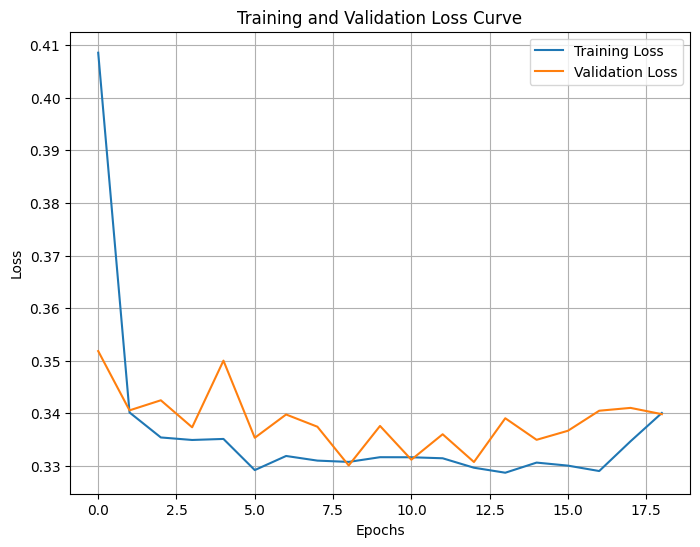

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-4-24737755b8b6>:57: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * (precision * recall) / (precision + recall)


Test Loss: 0.3524
Test Accuracy: 0.8878
Accuracy: 0.8878
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
IoU (Jaccard Index): 0.0000
Dice Coefficient: nan


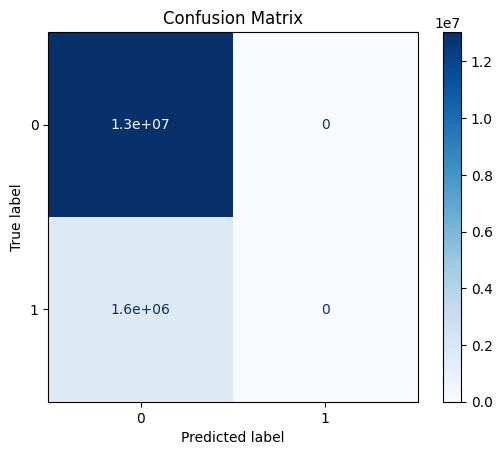

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, jaccard_score
)
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf

# Load saved files
model_path = '/content/drive/MyDrive/SegNet_model.h5'
history_path = '/content/drive/MyDrive/SegNet_training_history.pkl'
metrics_path = '/content/drive/MyDrive/SegNet_metrics.pkl'
y_true_path = '/content/drive/MyDrive/SegNet_y_true_flat.npy'
y_pred_path = '/content/drive/MyDrive/SegNet_y_pred_flat.npy'
predictions_path = '/content/drive/MyDrive/SegNet_test_predictions.npy'

# Load the saved model
segnet_model = tf.keras.models.load_model(model_path)

# Load history, evaluation metrics, and predictions
with open(history_path, 'rb') as file:
    history = pickle.load(file)

with open(metrics_path, 'rb') as file:
    metrics = pickle.load(file)

y_true_flat = np.load(y_true_path)
y_pred_flat = np.load(y_pred_path)
y_pred = np.load(predictions_path)

# Calculate binary predictions from probabilities
y_pred_binary = (y_pred_flat > 0.5).astype(np.uint8)

# Function to plot training and validation loss curve
def plot_loss_curve(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Loss Curve
plot_loss_curve(history)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true_flat, y_pred_binary)
precision = precision_score(y_true_flat, y_pred_binary)
recall = recall_score(y_true_flat, y_pred_binary)
f1 = f1_score(y_true_flat, y_pred_binary)
iou = jaccard_score(y_true_flat, y_pred_binary)
dice = 2 * (precision * recall) / (precision + recall)

# Print evaluation metrics
print(f"Test Loss: {metrics['test_loss']:.4f}")
print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU (Jaccard Index): {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_binary)

# Display confusion matrix using from_predictions method
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Function to visualize segmented images
def visualize_segmentation(test_gen, y_pred):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle("Sample Segmentation Results", fontsize=16)

    for i in range(3):
        # Load a batch of test images and their ground truth masks
        images, true_masks = test_gen[i]
        pred_masks = (y_pred[i * test_gen.batch_size:(i + 1) * test_gen.batch_size] > 0.5).astype(np.uint8)

        # Display original image, true mask, and predicted mask
        for j in range(3):
            axes[i, j].axis('off')

            if j == 0:
                axes[i, j].imshow(images[j].squeeze(), cmap='gray')
                axes[i, j].set_title("Original Image")
            elif j == 1:
                axes[i, j].imshow(true_masks[j].squeeze(), cmap='gray')
                axes[i, j].set_title("True Mask")
            else:
                axes[i, j].imshow(pred_masks[j].squeeze(), cmap='gray')
                axes[i, j].set_title("Predicted Mask")
    plt.tight_layout()
    plt.show()



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8878
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


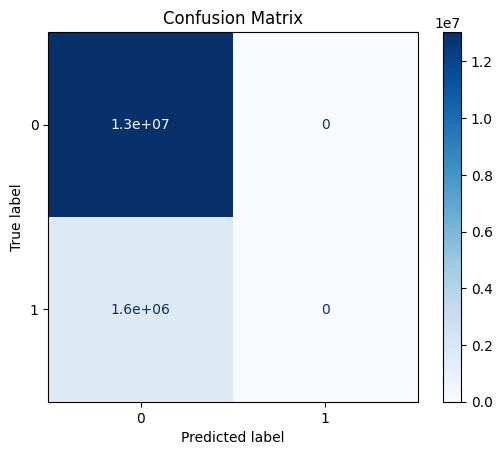

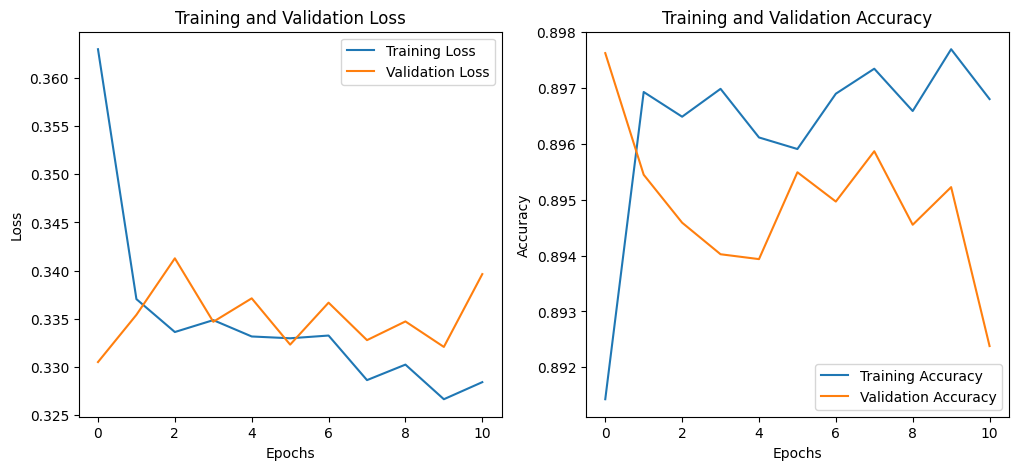

NameError: name 'test_gen' is not defined

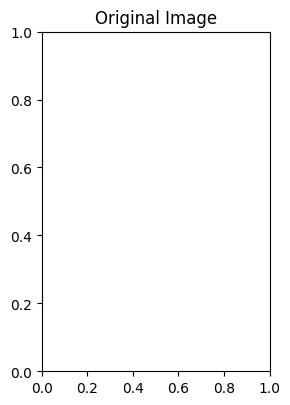

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pickle

# Load the saved predictions and ground truth labels
y_pred = np.load('/content/drive/MyDrive/SegNet_test_predictions.npy')
y_true_flat = np.load('/content/drive/MyDrive/SegNet_y_true_flat.npy')
y_pred_flat = np.load('/content/drive/MyDrive/SegNet_y_pred_flat.npy')

# Ensure predictions are binary (0 or 1)
threshold = 0.5
y_pred_binary = (y_pred_flat > threshold).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true_flat, y_pred_binary)
precision = precision_score(y_true_flat, y_pred_binary)
recall = recall_score(y_true_flat, y_pred_binary)
f1 = f1_score(y_true_flat, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_binary)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Load the training history
with open('/content/drive/MyDrive/SegNet_training_history.pkl', 'rb') as history_file:
    history = pickle.load(history_file)

# Plot training & validation loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



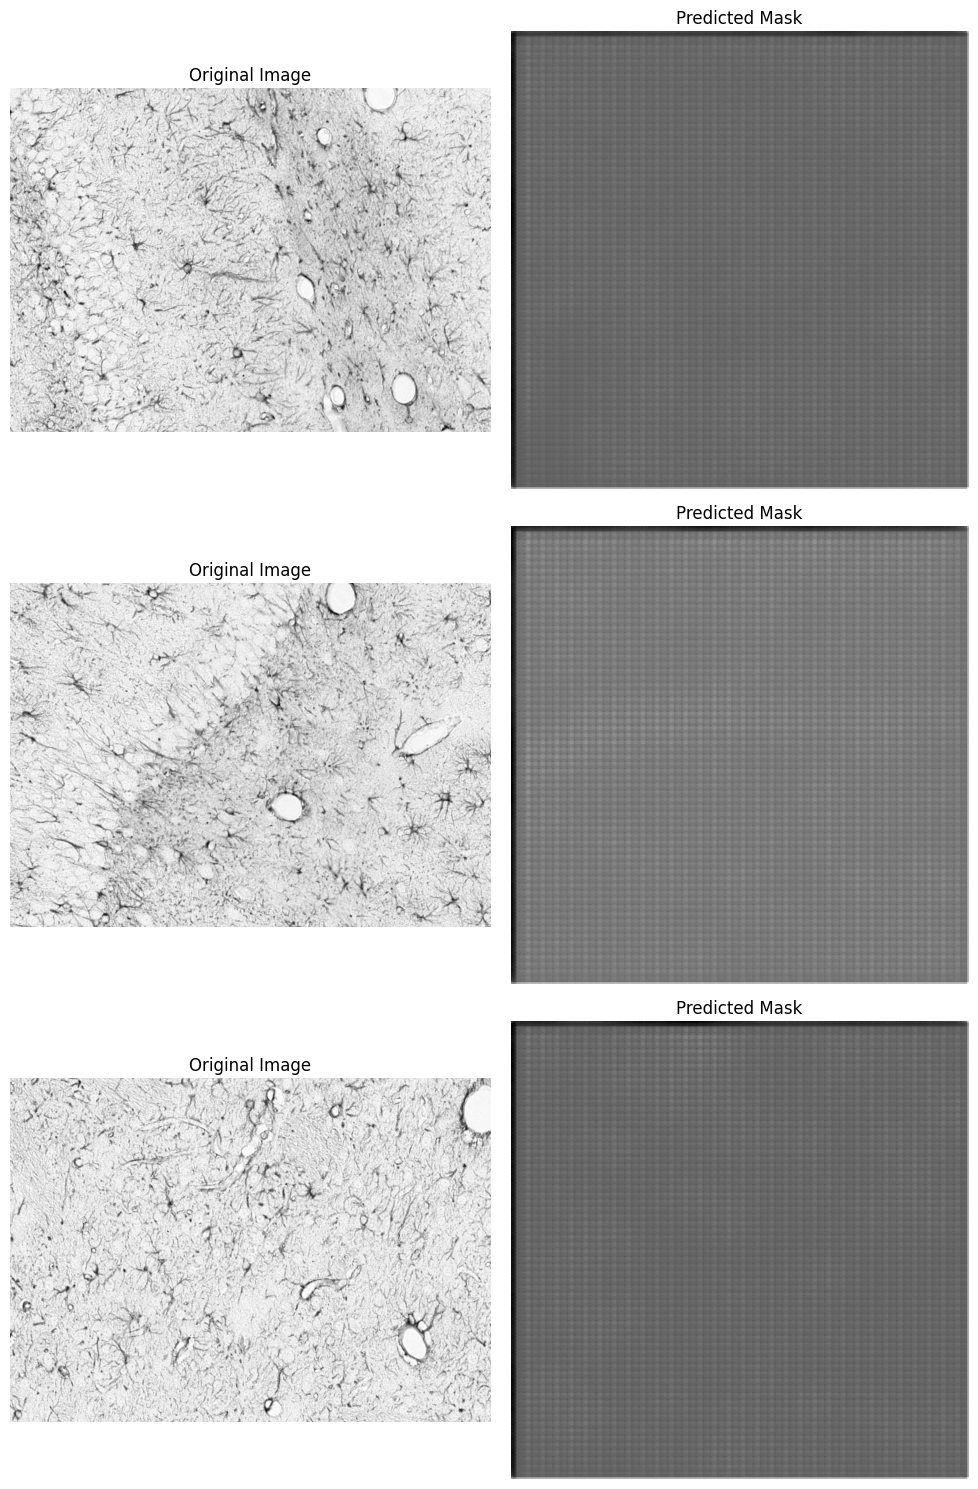

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import os
import random

# Load the saved predictions and ground truth labels
y_pred = np.load('/content/drive/MyDrive/SegNet_test_predictions.npy')

# Ensure predictions are binary (0 or 1)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

# Function to load TIFF images from the file path
def load_tiff_image(image_path):
    img = tiff.imread(image_path)
    if img.ndim == 2:  # Single-channel grayscale
        img = np.expand_dims(img, axis=-1)
    return img

# Visualization function using original images
def visualize_segmentation(image_paths, y_pred, num_samples=3):
    # Ensure we do not exceed the number of predictions
    num_images = min(len(image_paths), len(y_pred))
    indices = random.sample(range(num_images), num_samples)

    plt.figure(figsize=(10, num_samples * 5))

    for i, idx in enumerate(indices):
        # Load the original image
        img = load_tiff_image(image_paths[idx])
        pred_mask = y_pred[idx, :, :, 0]  # Ensure index does not go out of bounds

        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.title("Original Image")
        plt.imshow(img[:, :, 0], cmap='gray')
        plt.axis('off')

        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load your test images paths (update the path if needed)
test_images_path = '/content/drive/MyDrive/images'
test_images = sorted([os.path.join(test_images_path, file) for file in os.listdir(test_images_path) if file.endswith('.tif')])

# Visualize a few samples with their predicted masks
visualize_segmentation(test_images, y_pred)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Load the saved predictions
y_pred = np.load('/content/drive/MyDrive/SegNet_test_predictions.npy')

# Ensure predictions are binary (0 or 1)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

# Function to load TIFF images from the file path
def load_tiff_image(image_path):
    img = tiff.imread(image_path)
    if img.ndim == 2:  # Single-channel grayscale
        img = np.expand_dims(img, axis=-1)
    return img


# Paths to your ground truth masks (update the path if needed)
ground_truth_path = '/content/drive/MyDrive/positions'
ground_truth_files = sorted([os.path.join(ground_truth_path, file) for file in os.listdir(ground_truth_path) if file.endswith('.tif')])

# Ensure you have the same number of ground truth masks and predictions
assert len(ground_truth_files) == len(y_pred), "Mismatch in number of test masks and predicted masks."

# Initialize lists to store flattened mask arrays
y_true_flat = []
y_pred_flat = []

# Load ground truth and predicted masks, compute evaluation metrics
for i in range(len(y_pred)):
    # Load ground truth mask
    gt_mask = load_tiff_image(ground_truth_files[i])
    gt_mask = (gt_mask > 127).astype(np.uint8).flatten()  # Binarize and flatten ground truth mask

    # Flatten predicted mask
    pred_mask = y_pred_binary[i, :, :, 0].flatten()  # Assuming shape is (H, W, 1)

    # Append to lists
    y_true_flat.extend(gt_mask)
    y_pred_flat.extend(pred_mask)

# Convert lists to NumPy arrays
y_true_flat = np.array(y_true_flat)
y_pred_flat = np.array(y_pred_flat)

# Compute evaluation metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
iou = jaccard_score(y_true_flat, y_pred_flat)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score (Dice Coefficient): {f1:.4f}")
print(f"Intersection over Union (IoU): {iou:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

AssertionError: Mismatch in number of test masks and predicted masks.

In [ ]:
import os
import numpy as np
import cv2
from scipy.spatial import distance

# Load predicted masks and ground truths
y_pred = np.load('/content/drive/MyDrive/SegNet_test_predictions.npy')

# Parse cell data for ground truth (assuming 'path_to_file' contains the annotations)
def parse_cell_data(file_path):
    cell_data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                cell_id = int(parts[1])  # cell ID (if needed)
                x1 = int(parts[4])
                y1 = int(parts[5])
                x2 = int(parts[6])
                y2 = int(parts[7])

                # Calculate centroid
                cX = (x1 + x2) / 2
                cY = (y1 + y2) / 2
                cell_data.append((cX, cY))  # Store centroid
    return cell_data

# Function to load all ground truth centroids (assuming they are in separate txt files)
def load_all_ground_truths(masks_path):
    true_centroids_list = []
    for filename in sorted(os.listdir(masks_path)):  # Assuming files are sorted by frame number
        if filename.endswith('.txt'):
            file_path = os.path.join(masks_path, filename)
            true_centroids = parse_cell_data(file_path)
            true_centroids_list.append(true_centroids)
    return true_centroids_list

# Example usage: Load all ground truth centroids from the directory
masks_path = '/content/drive/MyDrive/positions'
true_centroids_list = load_all_ground_truths(masks_path)
print(true_centroids_list)

# Post-processing: Cell Tracking
def get_centroids(mask):

    # Binarize the mask (threshold at 0.5 for floating-point predictions)
    mask = (mask > 0.1).astype(np.uint8) * 255

    # Step 2: Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Debug: Print number of contours found
    print(f"Contours found: {len(contours)}")

    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))

    # Debug: Print centroids found
    print(f"Centroids found: {centroids}")

    # Return centroids or an empty list if none are found
    return centroids if centroids else []

def track_cells(previous_centroids, current_centroids, max_distance=50):
    matches = {}
    current_centroids_copy = current_centroids.copy()  # Avoid modifying the original list
    for prev in previous_centroids:
        min_dist = float('inf')
        best_match = None
        best_match_index = -1
        for i, curr in enumerate(current_centroids_copy):
            dist = distance.euclidean(prev, curr)
            if dist < min_dist and dist <= max_distance:
                min_dist = dist
                best_match = curr
                best_match_index = i
        if best_match is not None:
            matches[prev] = best_match
            # Remove matched centroid from the copy list
            current_centroids_copy.pop(best_match_index)
    return matches

# Process tracking across frames
# Process tracking across frames
segmented_masks = [mask.squeeze() for mask in y_pred]
previous_centroids = []
tracked_centroids = []

# Process frames to track centroids
for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    true_centroids = true_centroids_list[frame_idx] if frame_idx < len(true_centroids_list) else []

    matches = track_cells(previous_centroids, current_centroids)

    # Store the centroids of the current frame for tracking overview
    tracked_centroids.append(current_centroids)
    previous_centroids = current_centroids

# Print tracked centroids for each frame
print("Tracked centroids across frames:")
for i, centroids in enumerate(tracked_centroids):
    print(f"Frame {i + 1}: {centroids}")

[[(793.0, 440.0), (29.0, 620.0), (938.0, 185.0), (945.0, 272.0), (945.0, 647.0), (892.0, 398.5), (515.0, 241.5), (429.5, 453.5), (337.5, 464.0), (257.0, 437.0), (205.0, 550.5), (160.0, 545.0), (47.5, 229.5), (210.0, 223.5)], [(895.5, 404.0), (802.5, 34.0), (674.5, 506.5), (661.5, 191.5), (147.0, 32.0), (27.0, 319.5), (958.0, 268.0), (401.0, 108.0)], [(390.0, 399.0), (671.0, 551.0), (214.0, 678.0), (421.5, 186.5), (549.0, 30.5), (91.5, 640.0), (662.0, 135.0), (395.5, 512.0), (544.5, 462.0), (946.0, 586.5), (30.0, 393.5), (128.0, 299.5), (871.5, 637.5)], [(117.0, 317.5), (75.5, 265.0), (205.0, 560.5), (408.0, 506.5), (495.5, 441.5), (761.5, 40.0), (656.5, 366.0), (76.5, 414.5), (692.0, 491.0), (511.5, 538.5)], [(878.0, 446.5), (51.5, 563.0), (35.5, 611.0), (887.5, 654.0), (894.0, 205.5), (826.5, 318.0), (650.0, 670.5), (151.0, 655.5), (209.5, 484.5), (353.5, 618.0), (366.0, 509.0), (424.0, 415.0), (489.5, 300.5), (330.5, 27.0), (331.0, 150.0), (278.5, 92.5), (226.5, 130.5), (194.0, 310.0

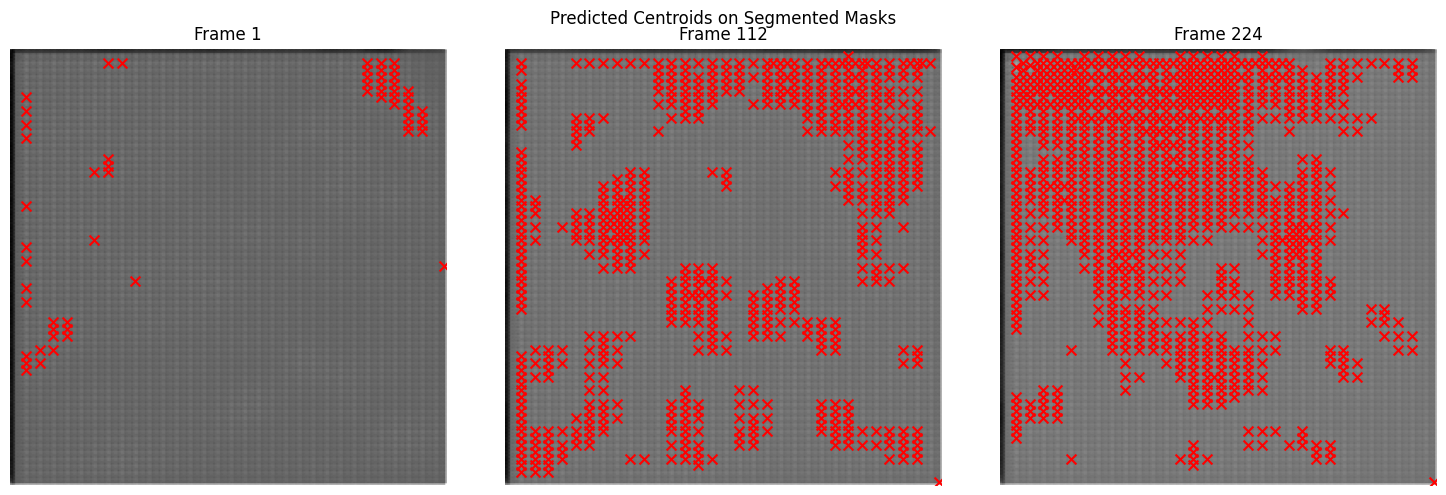

In [ ]:
import numpy as np
import cv2
import os
import tifffile as tiff
import matplotlib.pyplot as plt

# Load the saved predictions
y_pred = np.load('/content/drive/MyDrive/SegNet_test_predictions.npy')

# Function to extract centroids from a mask
def get_centroids(mask):
    # Binarize the mask (threshold at 0.1 for floating-point predictions)
    mask = (mask > 0.1).astype(np.uint8) * 255

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    return centroids

# Extract segmented masks
segmented_masks = [mask.squeeze() for mask in y_pred]

# Store centroids for visualization
all_centroids = []

# Get centroids for each frame
for frame_idx, mask in enumerate(segmented_masks):
    centroids = get_centroids(mask)
    all_centroids.append(centroids)

# Visualization function
def visualize_centroids(segmented_masks, all_centroids, num_frames=3):
    plt.figure(figsize=(15, 5))
    selected_frames = np.linspace(0, len(segmented_masks) - 1, num_frames, dtype=int)

    for i, frame_idx in enumerate(selected_frames):
        mask = segmented_masks[frame_idx]
        centroids = all_centroids[frame_idx]

        plt.subplot(1, num_frames, i + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Frame {frame_idx + 1}')

        # Plot centroids
        if centroids:
            centroids_x = [c[0] for c in centroids]
            centroids_y = [c[1] for c in centroids]
            plt.scatter(centroids_x, centroids_y, color='red', s=50, marker='x', label='Predicted Centroid')

        plt.axis('off')

    plt.suptitle("Predicted Centroids on Segmented Masks")
    plt.tight_layout()
    plt.show()

# Visualize 3 selected frames
visualize_centroids(segmented_masks, all_centroids, num_frames=3)

In [ ]:
# Track Consistency
def track_consistency(tracked_centroids):
    consistency = []
    for i in range(1, len(tracked_centroids)):
        previous_centroids = set(map(tuple, tracked_centroids[i - 1]))  # Convert to tuple for set operation
        current_centroids = set(map(tuple, tracked_centroids[i]))  # Convert to tuple for set operation
        matches = previous_centroids.intersection(current_centroids)
        consistency_frame = len(matches) / max(len(previous_centroids), len(current_centroids))
        consistency.append(consistency_frame)
    return np.mean(consistency) if consistency else 0

# Jaccard Index
def jaccard_index(pred_centroids, true_centroids):
    if not pred_centroids or not true_centroids:
        return 0
    pred_set = set(map(tuple, pred_centroids))
    true_set = set(map(tuple, true_centroids))
    intersection = len(pred_set.intersection(true_set))
    union = len(pred_set.union(true_set))
    return intersection / union if union > 0 else 0

# Mean Squared Error (MSE)
def mse_centroids(pred_centroids, true_centroids):
    if len(pred_centroids) != len(true_centroids):
        min_length = min(len(pred_centroids), len(true_centroids))
        pred_centroids = pred_centroids[:min_length]
        true_centroids = true_centroids[:min_length]
    mse = np.mean([distance.euclidean(np.array(pred), np.array(true))**2 for pred, true in zip(pred_centroids, true_centroids)])
    return mse

# Multiple Object Tracking Accuracy (MOTA)
def mota(pred_centroids_list, true_centroids_list):
    FP, FN, IDS = 0, 0, 0
    total_objects = sum(len(true_centroids) for true_centroids in true_centroids_list)

    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        matches = 0
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:  # max_distance threshold for match
                matches += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
        FN += len(true_centroids)
        IDS += abs(len(pred_centroids) - matches)

    return 1 - (FP + FN + IDS) / total_objects if total_objects > 0 else 0

# Multiple Object Tracking Precision (MOTP)
def motp(pred_centroids_list, true_centroids_list):
    total_dist = 0
    total_matches = 0

    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:  # max_distance threshold for match
                total_dist += closest_dist
                total_matches += 1
    return total_dist / total_matches if total_matches > 0 else 0

# ID F1 Score
def id_f1_score(pred_centroids_list, true_centroids_list):
    TP, FP, FN = 0, 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                TP += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
        FN += len(true_centroids)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Tracking Error (Euclidean Distance)
def tracking_error(pred_centroids_list, true_centroids_list):
    total_error = 0
    total_objects = 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred, true in zip(pred_centroids, true_centroids):
            total_error += distance.euclidean(pred, true)
            total_objects += 1
    return total_error / total_objects if total_objects > 0 else 0

# False Discovery Rate (FDR)
def false_discovery_rate(pred_centroids_list, true_centroids_list):
    FP, TP = 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                TP += 1
            else:
                FP += 1
    return FP / (FP + TP) if (FP + TP) > 0 else 0

# Process tracking across frames
segmented_masks = [mask.squeeze() for mask in y_pred]
previous_centroids = []
tracked_centroids = []

# Process frames to track centroids
for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    true_centroids = true_centroids_list[frame_idx] if frame_idx < len(true_centroids_list) else []

    matches = track_cells(previous_centroids, current_centroids)

    # Store the centroids of the current frame for tracking overview
    tracked_centroids.append(current_centroids)
    previous_centroids = current_centroids

# Compute all metrics
average_track_consistency = track_consistency(tracked_centroids)
average_jaccard_index = np.mean([jaccard_index(pred, true) for pred, true in zip(tracked_centroids, true_centroids_list)])
average_mse = np.mean([mse_centroids(pred, true) for pred, true in zip(tracked_centroids, true_centroids_list)])
average_mota = mota(tracked_centroids, true_centroids_list)
average_motp = motp(tracked_centroids, true_centroids_list)
average_id_f1_score = id_f1_score(tracked_centroids, true_centroids_list)
average_tracking_error = tracking_error(tracked_centroids, true_centroids_list)
average_false_discovery_rate = false_discovery_rate(tracked_centroids, true_centroids_list)

# Output the results
print(f"Track Consistency: {average_track_consistency}")
print(f"Jaccard Index: {average_jaccard_index}")
print(f"Mean Squared Error: {average_mse}")
print(f"MOTA: {average_mota}")
print(f"MOTP: {average_motp}")
print(f"ID F1 Score: {average_id_f1_score}")
print(f"Tracking Error: {average_tracking_error}")
print(f"False Discovery Rate: {average_false_discovery_rate}")

Track Consistency: 0.19984039089085487
Jaccard Index: 0.0
Mean Squared Error: 255605.88323076122
MOTA: -24.957035159116685
MOTP: 0
ID F1 Score: 0
Tracking Error: 489.4536631542782
False Discovery Rate: 1.0


Kalman filter tracking

In [ ]:
import os
import numpy as np
import cv2
from scipy.spatial import distance

# Load predicted masks and ground truths
y_pred = np.load('SegNet_test_predictions.npy')

# Parse cell data for ground truth (assuming 'path_to_file' contains the annotations)
def parse_cell_data(file_path):
    cell_data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'Cell':
                cell_id = int(parts[1])  # cell ID (if needed)
                x1 = int(parts[4])
                y1 = int(parts[5])
                x2 = int(parts[6])
                y2 = int(parts[7])

                # Calculate centroid
                cX = (x1 + x2) / 2
                cY = (y1 + y2) / 2
                cell_data.append((cX, cY))  # Store centroid
    return cell_data

# Function to load all ground truth centroids (assuming they are in separate txt files)
def load_all_ground_truths(masks_path):
    true_centroids_list = []
    for filename in sorted(os.listdir(masks_path)):
        if filename.endswith('.txt'):
            file_path = os.path.join(masks_path, filename)
            true_centroids = parse_cell_data(file_path)
            true_centroids_list.append(true_centroids)
    return true_centroids_list

# Example usage: Load all ground truth centroids from the directory
masks_path = '/Users/pavan/College/VII SEMESTER/Computer Vision/positions'
true_centroids_list = load_all_ground_truths(masks_path)
print(true_centroids_list)

# Post-processing: Cell Tracking
def get_centroids(mask):
    mask = (mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    return centroids

# Initialize Kalman Filter for tracking
def initialize_kalman_filter():
    kalman = cv2.KalmanFilter(4, 2)  # 4 state variables (x, y, velocity_x, velocity_y), 2 measurements (x, y)
    kalman.transitionMatrix = np.array([[1, 0, 1, 0],
                                        [0, 1, 0, 1],
                                        [0, 0, 1, 0],
                                        [0, 0, 0, 1]], dtype=np.float32)
    kalman.measurementMatrix = np.array([[1, 0, 0, 0],
                                         [0, 1, 0, 0]], dtype=np.float32)
    kalman.processNoiseCov = np.array([[1e-5, 0, 0, 0],
                                       [0, 1e-5, 0, 0],
                                       [0, 0, 1e-5, 0],
                                       [0, 0, 0, 1e-5]], dtype=np.float32)
    kalman.measurementNoiseCov = np.array([[1e-1, 0],
                                           [0, 1e-1]], dtype=np.float32)
    kalman.errorCovPost = np.eye(4, dtype=np.float32)
    return kalman

# Track cells using Kalman Filter
def track_cells_kalman(previous_centroids, current_centroids, kalman_filters, max_distance=50):
    matches = {}
    current_centroids_copy = current_centroids.copy()  # Avoid modifying the original list

    for prev_idx, prev in enumerate(previous_centroids):
        # Predict the next position using the Kalman filter
        kalman_filter = kalman_filters[prev_idx]
        predicted = kalman_filter.predict()

        # Convert predicted to a 1D array
        predicted_centroid = np.array([predicted[0][0], predicted[1][0]])

        # Find the closest true centroid to the predicted position
        min_dist = float('inf')
        best_match = None
        best_match_index = -1
        for i, curr in enumerate(current_centroids_copy):
            # Convert curr to a 1D array if necessary
            curr_array = np.array(curr)
            dist = distance.euclidean(predicted_centroid, curr_array)
            if dist < min_dist and dist <= max_distance:
                min_dist = dist
                best_match = curr
                best_match_index = i

        if best_match is not None:
            matches[previous_centroids[prev_idx]] = best_match
            current_centroids_copy.pop(best_match_index)
            # Update Kalman filter with the correct centroid (ensure it's a 2D array of shape (2, 1))
            kalman_filter.correct(np.array([[np.float32(best_match[0])], [np.float32(best_match[1])]]))

    return matches, kalman_filters

# Process tracking across frames
segmented_masks = [mask.squeeze() for mask in y_pred]
previous_centroids = []
tracked_centroids = []
kalman_filters = []

# Initialize Kalman Filters for the first frame
for _ in range(len(true_centroids_list[0])):  # Assuming the first frame has the same number of centroids as the predicted
    kalman_filters.append(initialize_kalman_filter())

# Process frames to track centroids
for frame_idx, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    true_centroids = true_centroids_list[frame_idx] if frame_idx < len(true_centroids_list) else []

    # Track cells with Kalman Filter
    matches, kalman_filters = track_cells_kalman(previous_centroids, current_centroids, kalman_filters)

    # Store the centroids of the current frame for tracking overview
    tracked_centroids.append(current_centroids)
    previous_centroids = current_centroids

# Print tracked centroids for each frame
print("Tracked centroids across frames:")
for i, centroids in enumerate(tracked_centroids):
    print(f"Frame {i + 1}: {centroids}")

[[(793.0, 440.0), (29.0, 620.0), (938.0, 185.0), (945.0, 272.0), (945.0, 647.0), (892.0, 398.5), (515.0, 241.5), (429.5, 453.5), (337.5, 464.0), (257.0, 437.0), (205.0, 550.5), (160.0, 545.0), (47.5, 229.5), (210.0, 223.5)], [(895.5, 404.0), (802.5, 34.0), (674.5, 506.5), (661.5, 191.5), (147.0, 32.0), (27.0, 319.5), (958.0, 268.0), (401.0, 108.0)], [(390.0, 399.0), (671.0, 551.0), (214.0, 678.0), (421.5, 186.5), (549.0, 30.5), (91.5, 640.0), (662.0, 135.0), (395.5, 512.0), (544.5, 462.0), (946.0, 586.5), (30.0, 393.5), (128.0, 299.5), (871.5, 637.5)], [(117.0, 317.5), (75.5, 265.0), (205.0, 560.5), (408.0, 506.5), (495.5, 441.5), (761.5, 40.0), (656.5, 366.0), (76.5, 414.5), (692.0, 491.0), (511.5, 538.5)], [(878.0, 446.5), (51.5, 563.0), (35.5, 611.0), (887.5, 654.0), (894.0, 205.5), (826.5, 318.0), (650.0, 670.5), (151.0, 655.5), (209.5, 484.5), (353.5, 618.0), (366.0, 509.0), (424.0, 415.0), (489.5, 300.5), (330.5, 27.0), (331.0, 150.0), (278.5, 92.5), (226.5, 130.5), (194.0, 310.0

In [ ]:
import numpy as np
from scipy.spatial import distance

# Calculate Track Consistency (percentage of frames where cell is correctly tracked across frames)
def track_consistency(tracked_centroids):
    consistency = []
    for i in range(1, len(tracked_centroids)):
        previous_centroids = set(map(tuple, tracked_centroids[i - 1]))  # Convert to tuple for set operation
        current_centroids = set(map(tuple, tracked_centroids[i]))  # Convert to tuple for set operation
        matches = previous_centroids.intersection(current_centroids)
        consistency_frame = len(matches) / max(len(previous_centroids), len(current_centroids))
        consistency.append(consistency_frame)
    return np.mean(consistency) if consistency else 0

# Jaccard Index between predicted and true centroids
def jaccard_index(pred_centroids, true_centroids):
    if not pred_centroids or not true_centroids:
        return 0
    pred_set = set(map(tuple, pred_centroids))
    true_set = set(map(tuple, true_centroids))
    intersection = len(pred_set.intersection(true_set))
    union = len(pred_set.union(true_set))
    return intersection / union if union > 0 else 0

# Mean Squared Error (MSE) for centroids
def mse_centroids(pred_centroids, true_centroids):
    if len(pred_centroids) != len(true_centroids):
        min_length = min(len(pred_centroids), len(true_centroids))
        pred_centroids = pred_centroids[:min_length]
        true_centroids = true_centroids[:min_length]
    mse = np.mean([distance.euclidean(np.array(pred), np.array(true))**2 for pred, true in zip(pred_centroids, true_centroids)])
    return mse

# Calculate MOTA (Multiple Object Tracking Accuracy)
def mota(pred_centroids_list, true_centroids_list):
    FP, FN, IDS = 0, 0, 0
    total_objects = sum(len(true_centroids) for true_centroids in true_centroids_list)

    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        matches = 0
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:  # max_distance threshold for match
                matches += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
        FN += len(true_centroids)
        IDS += abs(len(pred_centroids) - matches)

    return 1 - (FP + FN + IDS) / total_objects if total_objects > 0 else 0

# Calculate MOTP (Multiple Object Tracking Precision)
def motp(pred_centroids_list, true_centroids_list):
    total_dist = 0
    total_matches = 0

    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:  # max_distance threshold for match
                total_dist += closest_dist
                total_matches += 1
    return total_dist / total_matches if total_matches > 0 else 0

# Calculate ID F1 Score (ID Precision and Recall)
def id_f1_score(pred_centroids_list, true_centroids_list):
    TP, FP, FN = 0, 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                TP += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
        FN += len(true_centroids)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Calculate Tracking Error (Euclidean Distance between predicted and true centroids)
def tracking_error(pred_centroids_list, true_centroids_list):
    total_error = 0
    total_objects = 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred, true in zip(pred_centroids, true_centroids):
            total_error += distance.euclidean(pred, true)
            total_objects += 1
    return total_error / total_objects if total_objects > 0 else 0

# Calculate False Discovery Rate (FDR)
def false_discovery_rate(pred_centroids_list, true_centroids_list):
    FP, TP = 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                TP += 1
            else:
                FP += 1
    return FP / (FP + TP) if (FP + TP) > 0 else 0

# Initialize metrics
track_consistencies = []
jaccard_indices = []
mse_values = []
motas = []
motps = []
id_f1_scores = []
tracking_errors = []
fdrs = []

# Iterate through the frames and calculate the metrics
for i, (pred_centroids, true_centroids) in enumerate(zip(tracked_centroids, true_centroids_list)):
    # Track consistency for the whole sequence (from frame 1 to current frame)
    if i > 0:
        track_consistencies.append(track_consistency(tracked_centroids[:i+1]))

    # Jaccard Index for current frame
    jaccard_indices.append(jaccard_index(pred_centroids, true_centroids))

    # MSE for current frame
    mse_values.append(mse_centroids(pred_centroids, true_centroids))

# Calculate summary values for each metric
average_track_consistency = np.mean(track_consistencies) if track_consistencies else 0
average_jaccard_index = np.mean(jaccard_indices)
average_mse = np.mean(mse_values)
average_mota = mota(tracked_centroids, true_centroids_list)
average_motp = motp(tracked_centroids, true_centroids_list)
average_id_f1 = id_f1_score(tracked_centroids, true_centroids_list)
average_tracking_error = tracking_error(tracked_centroids, true_centroids_list)
average_fdr = false_discovery_rate(tracked_centroids, true_centroids_list)

# Print the results
print(f"Track Consistency (average): {average_track_consistency:.4f}")
print(f"Jaccard Index (average): {average_jaccard_index:.4f}")
print(f"Mean Squared Error (average): {average_mse:.4f}")
print(f"MOTA (Multiple Object Tracking Accuracy): {average_mota:.4f}")
print(f"MOTP (Multiple Object Tracking Precision): {average_motp:.4f}")
print(f"ID F1 Score: {average_id_f1:.4f}")
print(f"Tracking Error (average): {average_tracking_error:.4f}")
print(f"False Discovery Rate (FDR): {average_fdr:.4f}")

Track Consistency (average): 1.0000
Jaccard Index (average): 0.0000
Mean Squared Error (average): 323147.3862
MOTA (Multiple Object Tracking Accuracy): 0.7712
MOTP (Multiple Object Tracking Precision): 44.3165
ID F1 Score: 0.0024
Tracking Error (average): 513.7119
False Discovery Rate (FDR): 1.0000


In [ ]:
import numpy as np
import cv2
from scipy.spatial import distance

# Load predicted masks generated by HRNet
y_pred_hrnet = np.load('SegNet_test_predictions.npy')  # Update this path if needed

# Function to get centroids from a binary mask
def get_centroids(mask):
    mask = (mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    return centroids

# Nearest Neighbor Tracking function
def nearest_neighbor_tracking(previous_centroids, current_centroids, max_distance=50):
    matched_centroids = []
    remaining_centroids = current_centroids.copy()

    for prev_centroid in previous_centroids:
        best_match = None
        min_dist = max_distance
        for current_centroid in remaining_centroids:
            dist = distance.euclidean(prev_centroid, current_centroid)
            if dist < min_dist:
                min_dist = dist
                best_match = current_centroid

        if best_match:
            matched_centroids.append(best_match)
            remaining_centroids.remove(best_match)
        else:
            matched_centroids.append(prev_centroid)  # Carry forward unmatched centroids

    # Any remaining centroids in the current frame are new detections
    matched_centroids.extend(remaining_centroids)
    return matched_centroids

# Process tracking across frames using HRNet predictions with Nearest Neighbor Tracking
segmented_masks = [mask.squeeze() for mask in y_pred_hrnet]
tracked_centroids = []

for i, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    if i == 0:
        # Initialize with the first frame's centroids
        tracked_centroids.append(current_centroids)
    else:
        previous_centroids = tracked_centroids[-1]
        tracked_frame_centroids = nearest_neighbor_tracking(previous_centroids, current_centroids)
        tracked_centroids.append(tracked_frame_centroids)

# Summary of tracked centroids
print("Tracked centroids across frames (SegNet with Nearest Neighbors):")
for i, centroids in enumerate(tracked_centroids):
    print(f"Frame {i + 1}: {centroids}")

Tracked centroids across frames (SegNet with Nearest Neighbors):
Frame 1: [(127, 127)]
Frame 2: [(127, 127)]
Frame 3: [(127, 127)]
Frame 4: [(127, 127)]
Frame 5: [(127, 127)]
Frame 6: [(127, 127)]
Frame 7: [(127, 127)]
Frame 8: [(127, 127)]
Frame 9: [(127, 127)]
Frame 10: [(127, 127)]
Frame 11: [(127, 127)]
Frame 12: [(127, 127)]
Frame 13: [(127, 127)]
Frame 14: [(127, 127)]
Frame 15: [(127, 127)]
Frame 16: [(127, 127)]
Frame 17: [(127, 127)]
Frame 18: [(127, 127)]
Frame 19: [(127, 127)]
Frame 20: [(127, 127)]
Frame 21: [(127, 127)]
Frame 22: [(127, 127)]
Frame 23: [(127, 127)]
Frame 24: [(127, 127)]
Frame 25: [(127, 127)]
Frame 26: [(127, 127)]
Frame 27: [(127, 127)]
Frame 28: [(127, 127)]
Frame 29: [(127, 127)]
Frame 30: [(127, 127)]
Frame 31: [(127, 127)]
Frame 32: [(127, 127)]
Frame 33: [(127, 127)]
Frame 34: [(127, 127)]
Frame 35: [(127, 127)]
Frame 36: [(127, 127)]
Frame 37: [(127, 127)]
Frame 38: [(127, 127)]
Frame 39: [(127, 127)]
Frame 40: [(127, 127)]
Frame 41: [(127, 127)]
F

In [ ]:
# Metrics functions

# Track Consistency
def track_consistency(tracked_centroids):
    consistency = []
    for i in range(1, len(tracked_centroids)):
        previous_centroids = set(map(tuple, tracked_centroids[i - 1]))  # Convert to tuple for set operation
        current_centroids = set(map(tuple, tracked_centroids[i]))  # Convert to tuple for set operation
        matches = previous_centroids.intersection(current_centroids)
        consistency_frame = len(matches) / max(len(previous_centroids), len(current_centroids))
        consistency.append(consistency_frame)
    return np.mean(consistency) if consistency else 0

# Jaccard Index
def jaccard_index(pred_centroids, true_centroids):
    if not pred_centroids or not true_centroids:
        return 0
    pred_set = set(map(tuple, pred_centroids))
    true_set = set(map(tuple, true_centroids))
    intersection = len(pred_set.intersection(true_set))
    union = len(pred_set.union(true_set))
    return intersection / union if union > 0 else 0

# Mean Squared Error (MSE)
def mse_centroids(pred_centroids, true_centroids):
    if len(pred_centroids) != len(true_centroids):
        min_length = min(len(pred_centroids), len(true_centroids))
        pred_centroids = pred_centroids[:min_length]
        true_centroids = true_centroids[:min_length]
    mse = np.mean([distance.euclidean(np.array(pred), np.array(true))**2 for pred, true in zip(pred_centroids, true_centroids)])
    return mse

# Multiple Object Tracking Accuracy (MOTA)
def mota(pred_centroids_list, true_centroids_list):
    FP, FN, IDS = 0, 0, 0
    total_objects = sum(len(true_centroids) for true_centroids in true_centroids_list)

    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        matches = 0
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:  # max_distance threshold for match
                matches += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
        FN += len(true_centroids)
        IDS += abs(len(pred_centroids) - matches)

    return 1 - (FP + FN + IDS) / total_objects if total_objects > 0 else 0

# Multiple Object Tracking Precision (MOTP)
def motp(pred_centroids_list, true_centroids_list):
    total_dist = 0
    total_matches = 0

    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:  # max_distance threshold for match
                total_dist += closest_dist
                total_matches += 1
    return total_dist / total_matches if total_matches > 0 else 0

# ID F1 Score
def id_f1_score(pred_centroids_list, true_centroids_list):
    TP, FP, FN = 0, 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                TP += 1
                true_centroids.remove(closest_true)
            else:
                FP += 1
        FN += len(true_centroids)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Tracking Error (Euclidean Distance)
def tracking_error(pred_centroids_list, true_centroids_list):
    total_error = 0
    total_objects = 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred, true in zip(pred_centroids, true_centroids):
            total_error += distance.euclidean(pred, true)
            total_objects += 1
    return total_error / total_objects if total_objects > 0 else 0

# False Discovery Rate (FDR)
def false_discovery_rate(pred_centroids_list, true_centroids_list):
    FP, TP = 0, 0
    for pred_centroids, true_centroids in zip(pred_centroids_list, true_centroids_list):
        for pred in pred_centroids:
            closest_dist = float('inf')
            closest_true = None
            for true in true_centroids:
                dist = distance.euclidean(pred, true)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_true = true
            if closest_dist <= 50:
                TP += 1
            else:
                FP += 1
    return FP / (FP + TP) if (FP + TP) > 0 else 0

# Process tracking across frames using HRNet predictions with Nearest Neighbor Tracking
segmented_masks = [mask.squeeze() for mask in y_pred_hrnet]
tracked_centroids = []

for i, mask in enumerate(segmented_masks):
    current_centroids = get_centroids(mask)
    if i == 0:
        # Initialize with the first frame's centroids
        tracked_centroids.append(current_centroids)
    else:
        previous_centroids = tracked_centroids[-1]
        tracked_frame_centroids = nearest_neighbor_tracking(previous_centroids, current_centroids)
        tracked_centroids.append(tracked_frame_centroids)

# Compute all metrics
average_track_consistency = track_consistency(tracked_centroids)
average_jaccard_index = np.mean([jaccard_index(pred, true) for pred, true in zip(tracked_centroids, true_centroids_list)])
average_mse = np.mean([mse_centroids(pred, true) for pred, true in zip(tracked_centroids, true_centroids_list)])
average_mota = mota(tracked_centroids, true_centroids_list)
average_motp = motp(tracked_centroids, true_centroids_list)
average_id_f1_score = id_f1_score(tracked_centroids, true_centroids_list)
average_tracking_error = tracking_error(tracked_centroids, true_centroids_list)
average_false_discovery_rate = false_discovery_rate(tracked_centroids, true_centroids_list)

# Output the results
print(f"Track Consistency: {average_track_consistency}")
print(f"Jaccard Index: {average_jaccard_index}")
print(f"Mean Squared Error: {average_mse}")
print(f"MOTA: {average_mota}")
print(f"MOTP: {average_motp}")
print(f"ID F1 Score: {average_id_f1_score}")
print(f"Tracking Error: {average_tracking_error}")
print(f"False Discovery Rate: {average_false_discovery_rate}")

Track Consistency: 1.0
Jaccard Index: 0.0
Mean Squared Error: 327256.33035714284
MOTA: 0.7668182426106727
MOTP: 0
ID F1 Score: 0
Tracking Error: 513.7119396693239
False Discovery Rate: 1.0
